<a href="https://colab.research.google.com/github/cavadmanafov/skimlit/blob/main/skimlit_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rcs

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.74 MiB/s, done.
Updating files: 100% (13/13), done.
ls: cannot access 'pubmed-rcs': No such file or directory


In [ ]:
import os
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()
  

In [ ]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #empty dictionary for each line 
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line
  return abstract_samples



In [ ]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [ ]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd 
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
train_df["target"]

0           OBJECTIVE
1             METHODS
2             METHODS
3             METHODS
4             METHODS
             ...     
180035        RESULTS
180036        RESULTS
180037        RESULTS
180038    CONCLUSIONS
180039    CONCLUSIONS
Name: target, Length: 180040, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [ ]:
 !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-25 01:42:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-25 01:42:21 (40.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
baseline_preds = model_0.predict(val_sentences)

In [ ]:
from helper_functions import calculate_results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt 

In [ ]:
max_tokens = 68000
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = 55)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random 
target_sentence = random.choice(train_sentences)
print(f"Text: \n{target_sentence}")
print(f"\nLength of the target sentence: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text: 
in a prospective pilot study , stable patients ( @ % male , @ @ years old ) with child-pugh class a or b cirrhosis ( mean model for end-stage liver disease score , @ @ ) were randomly assigned to groups that received exercise training ( n = @ ) or usual care ( controls , n = @ ) at the university of alberta hospital in canada from february through june @ .

Length of the target sentence: 358

Vectorized text: [[    5     8   241   689    17   729    12   564    64  1191     7 14159
   1024     8    16   186  2828    57   314    11  4384   604   114   101
      9    92   123     6    24    28    80   177   155    40    16   370
     77   459    40    15     2   735     4 10463   237     5  3106    27
   1886   313  1367     0     0     0     0]]


In [ ]:
rct_20k_text_vectorizer = text_vectorizer.get_vocabulary()
rct_20k_text_vectorizer[:5]

['', '[UNK]', 'the', 'and', 'of']

In [ ]:
token_embed = tf.keras.layers.Embedding(input_dim = len(rct_20k_text_vectorizer),
                                        output_dim = 128,
                                        mask_zero = True,
                                        name = "token_embedding")

In [ ]:
print(f"Text before vectorization: \n{target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"\nText after vectorization (before embedding:\n{vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"\nText after vectorization and embedding:\n{embedded_sentence}")

Text before vectorization: 
in a prospective pilot study , stable patients ( @ % male , @ @ years old ) with child-pugh class a or b cirrhosis ( mean model for end-stage liver disease score , @ @ ) were randomly assigned to groups that received exercise training ( n = @ ) or usual care ( controls , n = @ ) at the university of alberta hospital in canada from february through june @ .

Text after vectorization (before embedding:
[[    5     8   241   689    17   729    12   564    64  1191     7 14159
   1024     8    16   186  2828    57   314    11  4384   604   114   101
      9    92   123     6    24    28    80   177   155    40    16   370
     77   459    40    15     2   735     4 10463   237     5  3106    27
   1886   313  1367     0     0     0     0]]

Text after vectorization and embedding:
[[[ 0.02526018  0.01172876 -0.04931485 ... -0.00202068  0.00779384
    0.00346975]
  [-0.03223702 -0.04995158 -0.01697923 ...  0.00662309  0.0180398
   -0.01254654]
  [-0.00913526 -0.00

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
label_encoder

LabelEncoder()

In [ ]:
num_classes =len(label_encoder.classes_)

In [ ]:
inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "input_layer")
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = tf.keras.layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu")(token_embeddings)
x = tf.keras.layers.GlobalAveragePooling1D(name = "global_avearge_poolind_1d")(x)
outputs = tf.keras.layers.Dense(num_classes, activation = "softmax", name = "output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_avearge_poolind_1d (  (None, 64)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 output_layer (Dense)        (None, 5)                 325   

In [ ]:
history_model_1 = model_1.fit(train_dataset,
                              epochs = 3,
                              validation_data = val_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_steps = int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 38s 50ms/step - loss: 0.9140 - accuracy: 0.6398 - val_loss: 0.6805 - val_accuracy: 0.7384
Epoch 2/3
562/562 [==============================] - 6s 12ms/step - loss: 0.6583 - accuracy: 0.7563 - val_loss: 0.6317 - val_accuracy: 0.7696
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6190 - accuracy: 0.7736 - val_loss: 0.5990 - val_accuracy: 0.7829


In [ ]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6017 - accuracy: 0.7837


[0.6017243266105652, 0.783728301525116]

In [ ]:
model_1_pred_probs = model_1.predict(val_dataset) 
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.33835953e-01, 1.97500795e-01, 5.95951229e-02, 2.87683219e-01,
         2.13849116e-02],
        [4.60544258e-01, 2.66543806e-01, 1.03257513e-02, 2.55595028e-01,
         6.99119829e-03],
        [1.37593985e-01, 5.20359864e-03, 8.64096161e-04, 8.56320560e-01,
         1.77906204e-05],
        ...,
        [4.45747082e-06, 8.22726230e-04, 6.29884831e-04, 3.25100473e-06,
         9.98539686e-01],
        [4.94960546e-02, 4.27792847e-01, 1.08937986e-01, 6.30050749e-02,
         3.50768119e-01],
        [1.63266957e-01, 6.81099355e-01, 3.79110202e-02, 4.07040752e-02,
         7.70186856e-02]], dtype=float32), (30212, 5))

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
import tensorflow_hub as hub 
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "universal_sentence_encoder")

In [ ]:
import random
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: \n{random_train_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Random sentence after embedding: \n{use_embedded_sentence}")


Random sentence: 
compared with placebo ( n = @ ) , children receiving synbiotic ( n = @ ) had significantly fewer days of reported fever ( @ vs @ , p < @ ) , significant improvement in social functioning ( p < @ ; pre-to-end intervention ) , and school functioning ( p < @ ; pre-to-mid intervention ) .

Random sentence after embedding: 
[[-1.56342685e-02 -5.16673811e-02 -9.00507625e-03 -6.25103936e-02
  -6.89946488e-02  5.15423082e-02  5.20353317e-02 -2.65731756e-02
   5.30892797e-02  4.27800752e-02  7.37428889e-02  2.31769811e-02
   3.92282419e-02 -4.09080833e-03  4.29756120e-02 -5.05160019e-02
  -7.73735493e-02  2.77261846e-02 -4.70135398e-02 -7.06155002e-02
   7.68486783e-02  3.10526434e-02 -1.95722636e-02 -1.43895461e-03
  -1.31043158e-02  5.43082990e-02 -1.66364806e-03 -2.74668727e-02
  -4.30797637e-02  3.56557081e-04  3.31710726e-02  7.72214010e-02
  -1.54193146e-02 -4.44633216e-02 -5.51212346e-03  4.69182692e-02
  -4.98552108e-03 -6.51457235e-02 -3.98141481e-02 -3.26152332e-02
 

In [ ]:
inputs = tf.keras.layers.Input(shape = [], dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = tf.keras.layers.Dense(128, activation = "relu")(pretrained_embedding)
outputs = tf.keras.layers.Dense(num_classes, activation = "softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = val_dataset,
                              validation_steps = int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 13ms/step - loss: 0.9141 - accuracy: 0.6486 - val_loss: 0.7984 - val_accuracy: 0.6875
Epoch 2/3
562/562 [==============================] - 8s 13ms/step - loss: 0.7704 - accuracy: 0.7001 - val_loss: 0.7579 - val_accuracy: 0.7025
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7542 - accuracy: 0.7124 - val_loss: 0.7411 - val_accuracy: 0.7161


In [ ]:
def split_chars(text):
  return " ".join(list(text))
split_chars(random_train_sentence)

'c o m p a r e d   w i t h   p l a c e b o   (   n   =   @   )   ,   c h i l d r e n   r e c e i v i n g   s y n b i o t i c   (   n   =   @   )   h a d   s i g n i f i c a n t l y   f e w e r   d a y s   o f   r e p o r t e d   f e v e r   (   @   v s   @   ,   p   <   @   )   ,   s i g n i f i c a n t   i m p r o v e m e n t   i n   s o c i a l   f u n c t i o n i n g   (   p   <   @   ;   p r e - t o - e n d   i n t e r v e n t i o n   )   ,   a n d   s c h o o l   f u n c t i o n i n g   (   p   <   @   ;   p r e - t o - m i d   i n t e r v e n t i o n   )   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
val_chars[:5]

['i g e   s e n s i t i z a t i o n   t o   a s p e r g i l l u s   f u m i g a t u s   a n d   a   p o s i t i v e   s p u t u m   f u n g a l   c u l t u r e   r e s u l t   a r e   c o m m o n   i n   p a t i e n t s   w i t h   r e f r a c t o r y   a s t h m a   .',
 'i t   i s   n o t   c l e a r   w h e t h e r   t h e s e   p a t i e n t s   w o u l d   b e n e f i t   f r o m   a n t i f u n g a l   t r e a t m e n t   .',
 'w e   s o u g h t   t o   d e t e r m i n e   w h e t h e r   a   @ - m o n t h   c o u r s e   o f   v o r i c o n a z o l e   i m p r o v e d   a s t h m a - r e l a t e d   o u t c o m e s   i n   p a t i e n t s   w i t h   a s t h m a   w h o   a r e   i g e   s e n s i t i z e d   t o   a   f u m i g a t u s   .',
 'a s t h m a t i c   p a t i e n t s   w h o   w e r e   i g e   s e n s i t i z e d   t o   a   f u m i g a t u s   w i t h   a   h i s t o r y   o f   a t   l e a s t   @   s e v e r e   e x a c e r b a t i o n s   i n   t h e   p r e v 

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

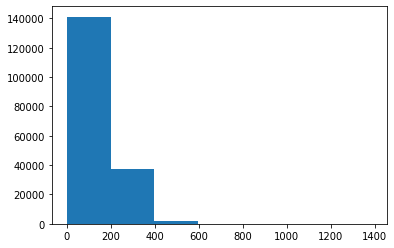

In [ ]:
import matplotlib.pyplot as plt 
plt.hist(char_lens, bins = 7)

In [ ]:
output_seq_char_length = int(np.percentile(char_lens, 95))
output_seq_char_length

290

In [ ]:
import string 
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
num_char_tokens = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens = num_char_tokens,
                                    output_sequence_length = output_seq_char_length,
                                    name = "char_vectorizer")


In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of differnt characters in char_vectorizer: {len(char_vocab)}")
print(f"5 most common words in char_vectorizer: {char_vocab[:5]}")
print(f"5 least common words in char_vectorizer: {char_vocab[-5:]}")


Number of differnt characters in char_vectorizer: 28
5 most common words in char_vectorizer: ['', '[UNK]', 'e', 't', 'i']
5 least common words in char_vectorizer: ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars = random.choice(train_chars)
print(f"Charified text: {random_train_chars}")
print(f"\nLength of the charified text: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorizer chars: {vectorized_chars}")
print(f"\nLength of the vectorized chars: {len(vectorized_chars[0])}")

Charified text: t h i s   @ - m o n t h   ,   d o u b l e - b l i n d   s t u d y   r a n d o m i z e d   p a t i e n t s   w i t h   m o d e r a t e   t o   s e v e r e   c o p d   (   a l r e a d y   o n   s t a n d a r d   t h e r a p y   )   t o   d a i l y   m k - @   a t   @   ,   @   ,   o r   @   m g   o r   p l a c e b o   .

Length of the charified text: 129

Vectorizer chars: [[ 3 13  4  9 15  7  6  3 13 10  7 16 22 12  2 22 12  4  6 10  9  3 16 10
  19  8  5  6 10  7 15  4 25  2 10 14  5  3  4  2  6  3  9 20  4  3 13 15
   7 10  2  8  5  3  2  3  7  9  2 21  2  8  2 11  7 14 10  5 12  8  2  5
  10 19  7  6  9  3  5  6 10  5  8 10  3 13  2  8  5 14 19  3  7 10  5  4
  12 19 15 23  5  3  7  8 15 18  7  8 14 12  5 11  2 22  7  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  

In [ ]:
char_embed = tf.keras.layers.Embedding(input_dim = len(char_vocab),
                                       output_dim = 25,
                                       mask_zero = True,
                                       name = "char_embed")

In [ ]:
print(f"Charifed text: \n {random_train_chars}\n")
print(f"\nVectorized char text: {char_vectorizer([random_train_chars])}")
print(f"\nCharified text after embedding layer: {char_embed(char_vectorizer([random_train_chars]))}")

Charifed text: 
 t h i s   @ - m o n t h   ,   d o u b l e - b l i n d   s t u d y   r a n d o m i z e d   p a t i e n t s   w i t h   m o d e r a t e   t o   s e v e r e   c o p d   (   a l r e a d y   o n   s t a n d a r d   t h e r a p y   )   t o   d a i l y   m k - @   a t   @   ,   @   ,   o r   @   m g   o r   p l a c e b o   .


Vectorized char text: [[ 3 13  4  9 15  7  6  3 13 10  7 16 22 12  2 22 12  4  6 10  9  3 16 10
  19  8  5  6 10  7 15  4 25  2 10 14  5  3  4  2  6  3  9 20  4  3 13 15
   7 10  2  8  5  3  2  3  7  9  2 21  2  8  2 11  7 14 10  5 12  8  2  5
  10 19  7  6  9  3  5  6 10  5  8 10  3 13  2  8  5 14 19  3  7 10  5  4
  12 19 15 23  5  3  7  8 15 18  7  8 14 12  5 11  2 22  7  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [ ]:
inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = tf.keras.layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu")(char_embeddings)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation = "relu", name = "output-layer")(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)


In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 7.2067 - accuracy: 0.3308 - val_loss: 7.0861 - val_accuracy: 0.3946
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 7.0072 - accuracy: 0.3530 - val_loss: 7.1794 - val_accuracy: 0.3205
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 7.1630 - accuracy: 0.3163 - val_loss: 7.1551 - val_accuracy: 0.3205


In [ ]:
token_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string, name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

char_inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

token_char_concat = tf.keras.layers.Concatenate(name = "token_char_hybrid")([token_model.output,
                                                                             char_model.output])

combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation = "relu")(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(num_classes, activation = "softmax")(final_dropout)

model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer)

In [ ]:
model_4.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)



In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) 

#Prefetch and batch
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) 

#Prefetch and batch
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_4 = model_4.fit(train_char_token_dataset, 
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 38s 50ms/step - loss: 0.9854 - accuracy: 0.6063 - val_loss: 0.7694 - val_accuracy: 0.7035
Epoch 2/3
562/562 [==============================] - 26s 47ms/step - loss: 0.8050 - accuracy: 0.6923 - val_loss: 0.7146 - val_accuracy: 0.7334
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.7781 - accuracy: 0.7018 - val_loss: 0.6915 - val_accuracy: 0.7357


In [ ]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)
train_total_lines_one_hot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
token_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string)
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

char_inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,
                            char_bi_lstm)

line_number_inputs = tf.keras.layers.Input(shape = (15,), dtype = tf.float32, name = "line_number_input")
x = tf.keras.layers.Dense(32, activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

total_lines_inputs = tf.keras.layers.Input(shape = (20,), dtype = tf.float32, name = "total_lines_input")
y = tf.keras.layers.Dense(32, activation = "relu")(total_lines_inputs)
total_line_model = tf.keras.Model(total_lines_inputs, y)

combined_embeddings = tf.keras.layers.Concatenate(name = "char_token_hybrid_embedding")([token_model.output,
                                                                                         char_model.output])

z = tf.keras.layers.Dense(256, activation = "relu")(combined_embeddings)
z = tf.keras.layers.Dropout(0.5)(z)

tribrid_embeddings = tf.keras.layers.Concatenate(name = "char_token_poisitional_embedding")([line_number_model.output,
                                                                                             total_line_model.output,
                                                                                             z])

output_layer = tf.keras.layers.Dense(5, activation = "softmax", name = "output_layer")(tribrid_embeddings)

model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   char_model.input,
                                   token_model.input,
                                   total_line_model.input],
                         outputs = output_layer)

In [ ]:
model_5.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_7[0][0]']                
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input_6[0][0]']         

In [ ]:
model_5.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)